In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from EDA import create_boxplot,test_pairs, remove_small_groupings, map_values, one_sample, cross_val_size
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from pandas.plotting import scatter_matrix
from pandas.plotting import boxplot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
import scipy.stats as stats
from scipy.stats import f_oneway
from scipy.stats import sem
from sklearn.model_selection import cross_val_score
from scipy.stats import ttest_1samp
from itertools import combinations 

In [3]:
sat = pd.read_excel('data/UCS-Satellite-Database.xlsx')
sat.head()
print(sat.shape)
sat.dropna(axis=1, how='all', inplace=True)

(6718, 67)


In [4]:
useable_data = sat.columns[0:24]
sat_cleaned = sat[useable_data]
sat_cleaned.head()

,Current Official Name of Satellite,Country/Org of UN Registry,Country of Operator/Owner,Operator/Owner,Users,Purpose,Detailed Purpose,Class of Orbit,Type of Orbit,Longitude of GEO (degrees),...,Period (minutes),Launch Mass (kg.),Dry Mass (kg.),Power (watts),Date of Launch,Expected Lifetime (yrs.),Contractor,Country of Contractor,Launch Site,Launch Vehicle
0,1HOPSAT-TD,NR,USA,Hera Systems,Commercial,Earth Observation,Infrared Imaging,LEO,Non-Polar Inclined,0.00,...,96.08,22.00,NaN,NaN,2019-12-11 00:00:00,0.50,Hera Systems,USA,Satish Dhawan Space Centre,PSLV
1,Aalto-1,Finland,Finland,Aalto University,Civil,Technology Development,NaN,LEO,Sun-Synchronous,0.00,...,94.70,4.50,NaN,4.50,2017-06-23 00:00:00,2.00,Aalto University,Finland,Satish Dhawan Space Centre,PSLV
2,AAt-4,Denmark,Denmark,University of Aalborg,Civil,Earth Observation,Automatic Identification System (AIS),LEO,Sun-Synchronous,0.00,...,95.90,1.00,NaN,NaN,2016-04-25 00:00:00,NaN,University of Aalborg,Denmark,Guiana Space Center,Soyuz-2.1a
3,ABS-2,NR,Multinational,Asia Broadcast Satellite Ltd.,Commercial,Communications,NaN,GEO,NaN,75.00,...,1436.03,6330.00,NaN,16000,2014-02-06 00:00:00,15.00,Space Systems/Loral,USA,Guiana Space Center,Ariane 5 ECA
4,ABS-2A,NR,Multinational,Asia Broadcast Satellite Ltd.,Commercial,Communications,NaN,GEO,NaN,-75.00,...,1436.10,1800.00,NaN,NaN,2016-06-15 00:00:00,15.00,Boeing Satellite Systems,USA,Cape Canaveral,Falcon 9


In [5]:
sat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6718 entries, 0 to 6717
Data columns (total 67 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Current Official Name of Satellite  6718 non-null   object 
 1   Country/Org of UN Registry          6718 non-null   object 
 2   Country of Operator/Owner           6718 non-null   object 
 3   Operator/Owner                      6718 non-null   object 
 4   Users                               6718 non-null   object 
 5   Purpose                             6718 non-null   object 
 6   Detailed Purpose                    1167 non-null   object 
 7   Class of Orbit                      6718 non-null   object 
 8   Type of Orbit                       6077 non-null   object 
 9   Longitude of GEO (degrees)          6716 non-null   float64
 10  Perigee (km)                        6718 non-null   int64  
 11  Apogee (km)                         6718 no

In [6]:
sat_cleaned.isna().sum()

Current Official Name of Satellite       0
Country/Org of UN Registry               0
Country of Operator/Owner                0
Operator/Owner                           0
Users                                    0
Purpose                                  0
Detailed Purpose                      5551
Class of Orbit                           0
Type of Orbit                          641
Longitude of GEO (degrees)               2
Perigee (km)                             0
Apogee (km)                              0
Eccentricity                             0
Inclination (degrees)                    0
Period (minutes)                        44
Launch Mass (kg.)                      243
Dry Mass (kg.)                        6274
Power (watts)                         6137
Date of Launch                           0
Expected Lifetime (yrs.)              1914
Contractor                               0
Country of Contractor                    0
Launch Site                              0
Launch Vehi

In [7]:
sat_cleaned.drop(['Detailed Purpose', 'Dry Mass (kg.)', 'Power (watts)'],axis=1, inplace= True)
sat_cleaned = remove_small_groupings(sat_cleaned,'Users',1)
sat_cleaned.dropna(subset='Expected Lifetime (yrs.)', inplace=True)

In [8]:
sat_cleaned['Users'].value_counts()

Commercial               4097
Government                280
Military                  148
Government/Commercial      96
Military/Commercial        77
Military/Government        54
Government/Civil           23
Civil                      19
Government/Military         3
Military/Civil              2
Civil/Government            1
Commercial/Military         1
Name: Users, dtype: int64

In [9]:
sat_cleaned['Type of Orbit'].value_counts()

Non-Polar Inclined       2878
Polar                     698
Sun-Synchronous           669
Molniya                    10
Elliptical                  7
Deep Highly Eccentric       7
Equatorial                  6
Cislunar                    1
Name: Type of Orbit, dtype: int64

In [10]:
sat_cleaned['Class of Orbit'].value_counts()

LEO           4161
GEO            486
MEO            120
Elliptical      34
Name: Class of Orbit, dtype: int64

In [11]:
sat_date = sat_cleaned
sat_date['Date of Launch'] = pd.to_datetime(sat_date['Date of Launch'])
sat_date['Decade'] = (sat_date['Date of Launch'].dt.year // 10) * 10

launch_count_by_decade = sat_date.groupby('Decade')['Date of Launch'].count()
print(launch_count_by_decade)

Decade
1980       2
1990      62
2000     275
2010     797
2020    3665
Name: Date of Launch, dtype: int64


In [12]:

mil_df = sat_cleaned[sat_cleaned['Users']!='Commercial']
mil_df = sat_cleaned
mil_df['Purpose'].value_counts()


Communications                                    4064
Earth Observation                                  461
Navigation/Global Positioning                      140
Space Science                                       50
Technology Development                              42
Navigation/Regional Positioning                     12
Earth Observation/Navigation                         9
Earth Science                                        7
Technology Demonstration                             6
Earth Observation                                    3
Earth Observation/Technology Development             2
Earth Observation/Space Science                      1
Communications/Navigation                            1
Communications/Technology Development                1
Earth Observation/Communications/Space Science       1
Space Observation                                    1
Name: Purpose, dtype: int64

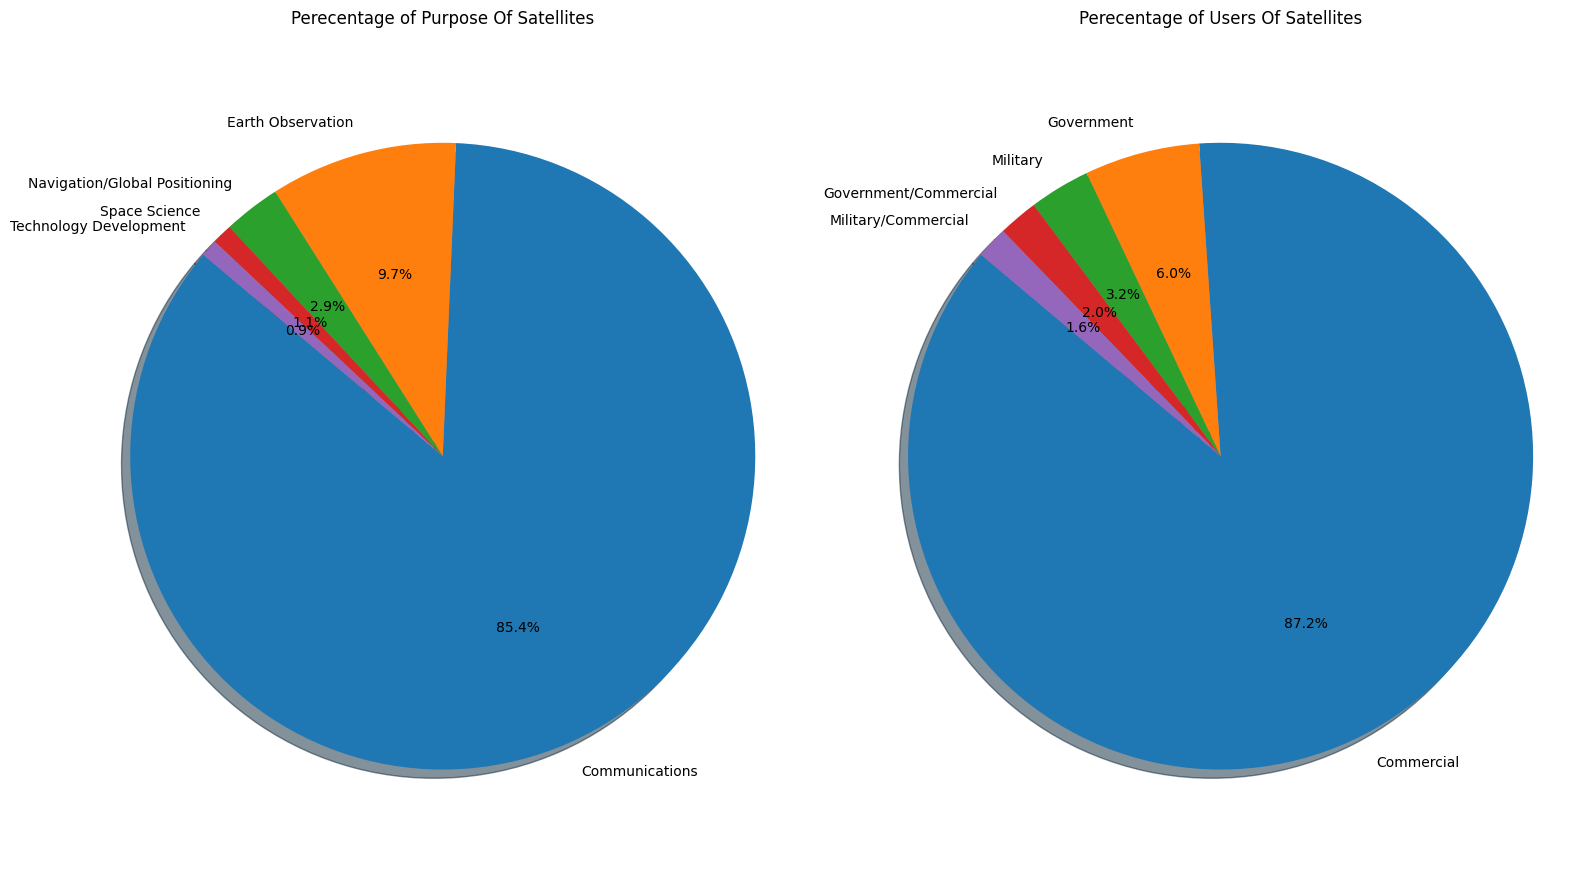

In [13]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
ax1.pie(mil_df['Purpose'].value_counts().head(5), labels=mil_df['Purpose'].value_counts().head(5).index, autopct='%1.1f%%', startangle=140,shadow=True)
ax1.axis('equal')
ax1.set_title('Perecentage of Purpose Of Satellites')

# Plot the second pie chart
ax2.pie(mil_df['Users'].value_counts().head(5), labels=mil_df['Users'].value_counts().head(5).index, autopct='%1.1f%%', startangle=140,shadow=True)
ax2.axis('equal')
ax2.set_title('Perecentage of Users Of Satellites')

# Adjust layout spacing
plt.tight_layout()
plt.show()


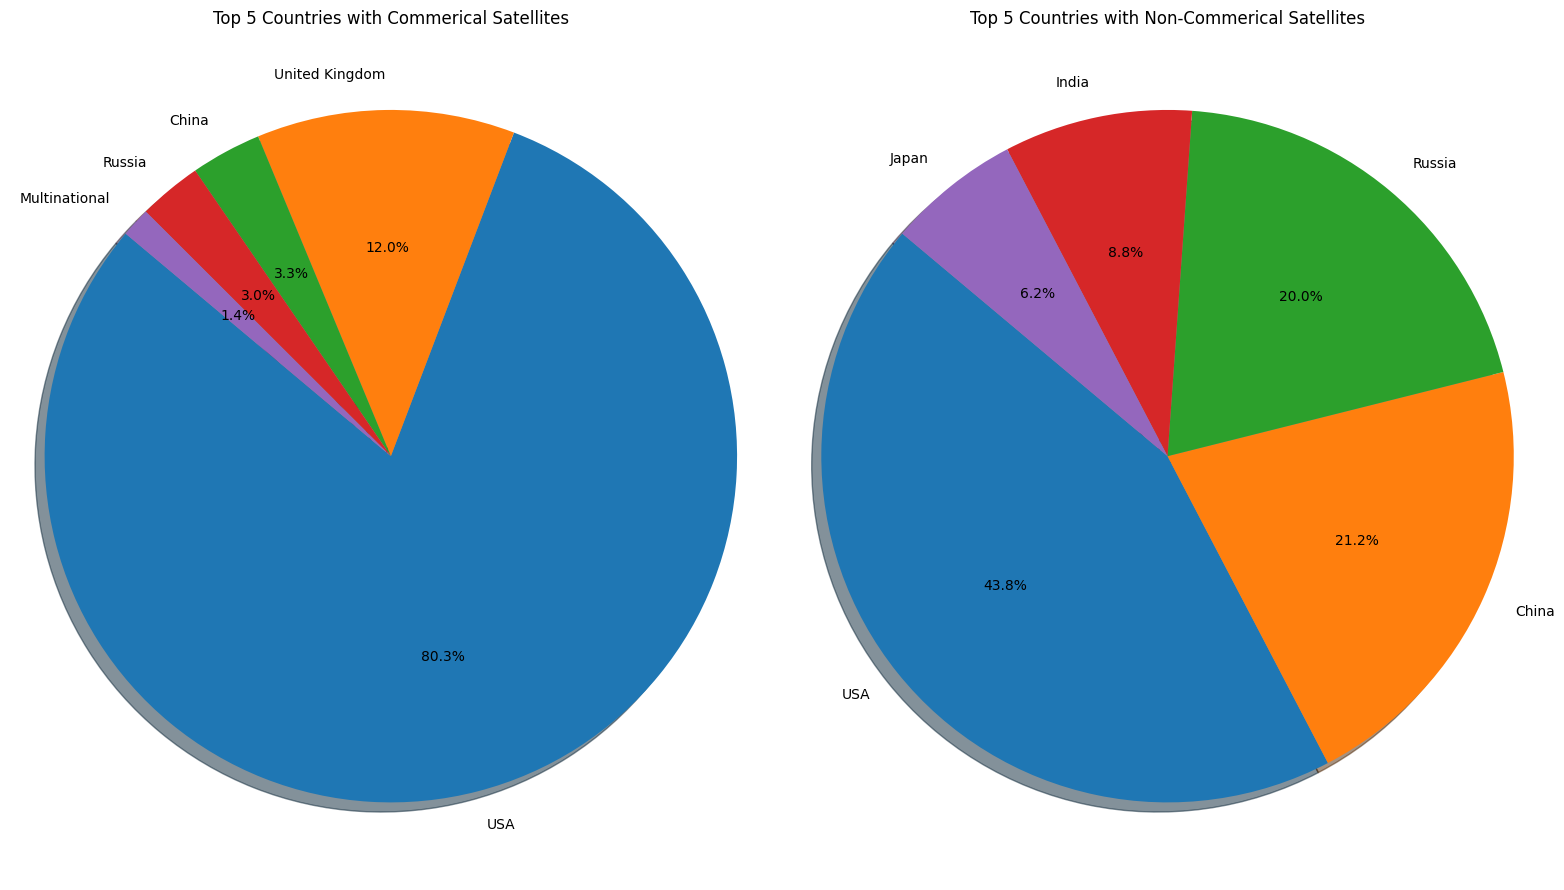

In [14]:



top_countries_com = mil_df['Country of Operator/Owner'].value_counts().head(5)
top_countries_com_labels = mil_df['Country of Operator/Owner'].value_counts().head(5).index
mil_sat = sat_cleaned[sat_cleaned['Users'] != 'Commercial']
mil_sat =mil_sat[mil_sat['Country/Org of UN Registry'] != 'NR']
top_countries = mil_sat['Country of Operator/Owner'].value_counts().head(5)
top_countries_labels = mil_sat['Country of Operator/Owner'].value_counts().head(5).index
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
ax1.pie(top_countries_com, labels=top_countries_com_labels, autopct='%1.1f%%', startangle=140,shadow=True)
ax1.axis('equal')
ax1.set_title('Top 5 Countries with Commerical Satellites')

# Plot the second pie chart
ax2.pie(top_countries, labels=top_countries_labels, autopct='%1.1f%%', startangle=140,shadow=True)
ax2.axis('equal')
ax2.set_title('Top 5 Countries with Non-Commerical Satellites')
mil_df['Country of Operator/Owner'].value_counts().head(5)
# Adjust layout spacing
plt.tight_layout()
plt.show()



In [15]:
mil_sat = sat_cleaned[sat_cleaned['Users'] != 'Commercial']
mil_sat =mil_sat[mil_sat['Country/Org of UN Registry'] != 'NR']
mil_sat['Country/Org of UN Registry'].value_counts()

USA                     214
Russia                   89
China                    88
India                    40
Japan                    30
ESA                      23
Germany                  16
Italy                     9
United Kingdom            8
NR (12/20)                8
France                    8
NR (9/22)                 7
South Korea               6
NR (1/22)                 6
NR (4/22)                 6
EUMETSAT                  5
Canada                    5
Algeria                   4
United Arab Emirates      4
NR (5/21)                 3
Pakistan                  3
NR (9/21)                 2
Mexico                    2
Brazil                    2
Australia                 2
Belarus                   2
Azerbaijan                2
Norway                    2
Egypt                     1
Thailand                  1
Argentina                 1
Israel                    1
Turkey                    1
Belgium                   1
Peru                      1
Finland             

In [16]:
mil_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4801 entries, 0 to 6715
Data columns (total 22 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Current Official Name of Satellite  4801 non-null   object        
 1   Country/Org of UN Registry          4801 non-null   object        
 2   Country of Operator/Owner           4801 non-null   object        
 3   Operator/Owner                      4801 non-null   object        
 4   Users                               4801 non-null   object        
 5   Purpose                             4801 non-null   object        
 6   Class of Orbit                      4801 non-null   object        
 7   Type of Orbit                       4276 non-null   object        
 8   Longitude of GEO (degrees)          4801 non-null   float64       
 9   Perigee (km)                        4801 non-null   int64         
 10  Apogee (km)             

746.9058429319372
742.8609456363257


array([[<Axes: xlabel='Launch Mass (kg.)', ylabel='Launch Mass (kg.)'>,
        <Axes: xlabel='Expected Lifetime (yrs.)', ylabel='Launch Mass (kg.)'>,
        <Axes: xlabel='Decade', ylabel='Launch Mass (kg.)'>,
        <Axes: xlabel='UsersMap', ylabel='Launch Mass (kg.)'>,
        <Axes: xlabel='OrbitTypeMap', ylabel='Launch Mass (kg.)'>,
        <Axes: xlabel='PurposeMaps', ylabel='Launch Mass (kg.)'>,
        <Axes: xlabel='OrbitClassMap', ylabel='Launch Mass (kg.)'>,
        <Axes: xlabel='CountryMap', ylabel='Launch Mass (kg.)'>,
        <Axes: xlabel='DecadeMap', ylabel='Launch Mass (kg.)'>],
       [<Axes: xlabel='Launch Mass (kg.)', ylabel='Expected Lifetime (yrs.)'>,
        <Axes: xlabel='Expected Lifetime (yrs.)', ylabel='Expected Lifetime (yrs.)'>,
        <Axes: xlabel='Decade', ylabel='Expected Lifetime (yrs.)'>,
        <Axes: xlabel='UsersMap', ylabel='Expected Lifetime (yrs.)'>,
        <Axes: xlabel='OrbitTypeMap', ylabel='Expected Lifetime (yrs.)'>,
        <Axes: xl

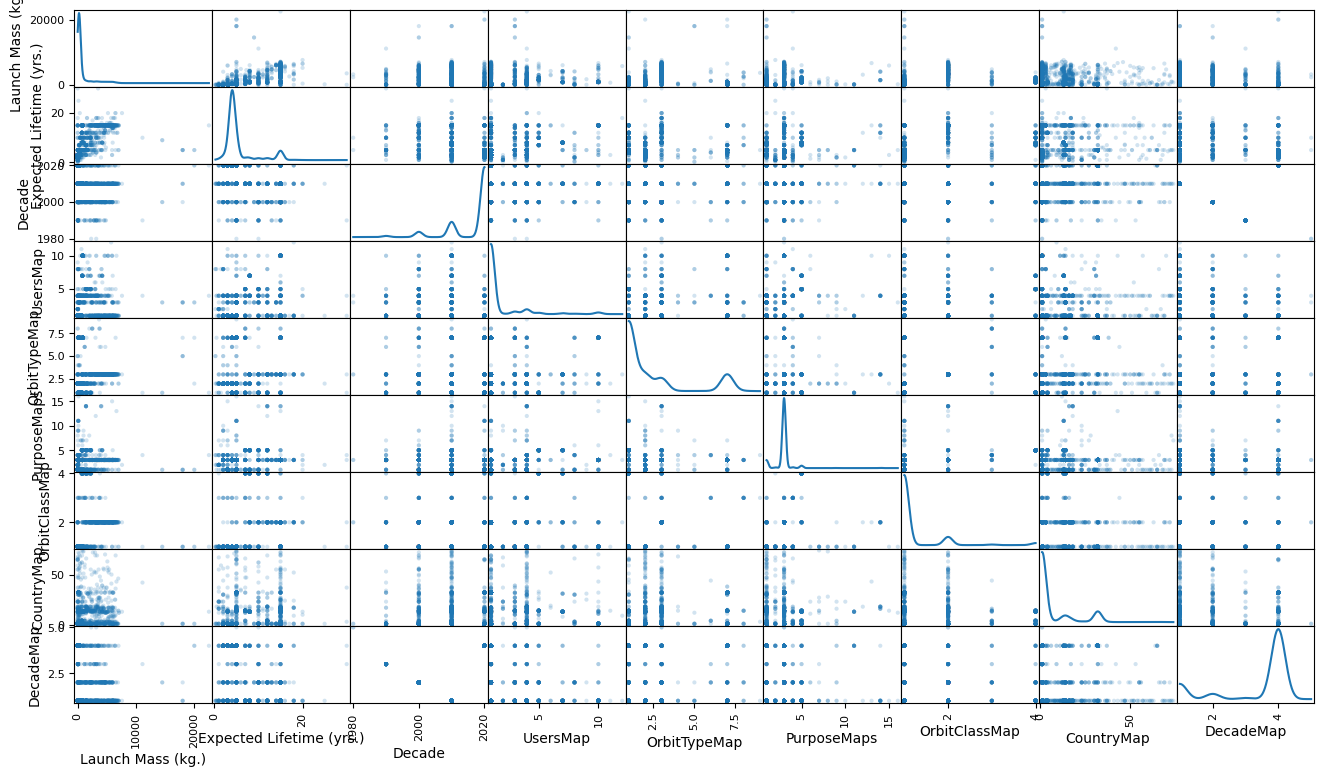

In [17]:
mil_df_scatter = mil_df[['Users','Purpose','Class of Orbit','Type of Orbit', 'Launch Mass (kg.)','Country of Operator/Owner','Expected Lifetime (yrs.)','Decade']]
# mil_df_scatter['Expected Lifetime (yrs.)'].fillna(mil_df_scatter['Expected Lifetime (yrs.)'].median(), inplace=True)
mil_df_scatter['Type of Orbit'] = mil_df_scatter['Type of Orbit'].fillna('Unknown')
mil_df_scatter['UsersMap'] = map_values(mil_df_scatter,'Users')
mil_df_scatter['OrbitTypeMap'] = map_values(mil_df_scatter,'Type of Orbit')
mil_df_scatter['PurposeMaps'] = map_values(mil_df_scatter,'Purpose')
mil_df_scatter['OrbitClassMap'] = map_values(mil_df_scatter,'Class of Orbit')
mil_df_scatter['CountryMap'] = map_values(mil_df_scatter,'Country of Operator/Owner')
mil_df_scatter['DecadeMap'] = map_values(mil_df_scatter,'Decade')
mil_df_scatter.isna().sum()
print(mil_df_scatter['Launch Mass (kg.)'].mean())
mil_df_scatter['Launch Mass (kg.)'] = mil_df_scatter['Launch Mass (kg.)'].fillna(0)
print(mil_df_scatter['Launch Mass (kg.)'].mean())

scatter_matrix(mil_df_scatter,diagonal='kde', alpha =.2, figsize=(16,9))

In [18]:
mil_df_scatter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4801 entries, 0 to 6715
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Users                      4801 non-null   object 
 1   Purpose                    4801 non-null   object 
 2   Class of Orbit             4801 non-null   object 
 3   Type of Orbit              4801 non-null   object 
 4   Launch Mass (kg.)          4801 non-null   float64
 5   Country of Operator/Owner  4801 non-null   object 
 6   Expected Lifetime (yrs.)   4801 non-null   float64
 7   Decade                     4801 non-null   int64  
 8   UsersMap                   4801 non-null   int64  
 9   OrbitTypeMap               4801 non-null   int64  
 10  PurposeMaps                4801 non-null   int64  
 11  OrbitClassMap              4801 non-null   int64  
 12  CountryMap                 4801 non-null   int64  
 13  DecadeMap                  4801 non-null   int64

## OLS MODEL

In [19]:

X = sm.add_constant(mil_df_scatter[['UsersMap','OrbitTypeMap','PurposeMaps','OrbitClassMap','Launch Mass (kg.)']])
y = mil_df_scatter['Expected Lifetime (yrs.)']
# Step 3: Build the OLS model
ols_model = sm.OLS(y, X)
results = ols_model.fit()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(results.summary())

                               OLS Regression Results                               
Dep. Variable:     Expected Lifetime (yrs.)   R-squared:                       0.588
Model:                                  OLS   Adj. R-squared:                  0.588
Method:                       Least Squares   F-statistic:                     1369.
Date:                      Wed, 09 Aug 2023   Prob (F-statistic):               0.00
Time:                              09:59:49   Log-Likelihood:                -10814.
No. Observations:                      4801   AIC:                         2.164e+04
Df Residuals:                          4795   BIC:                         2.168e+04
Df Model:                                 5                                         
Covariance Type:                  nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

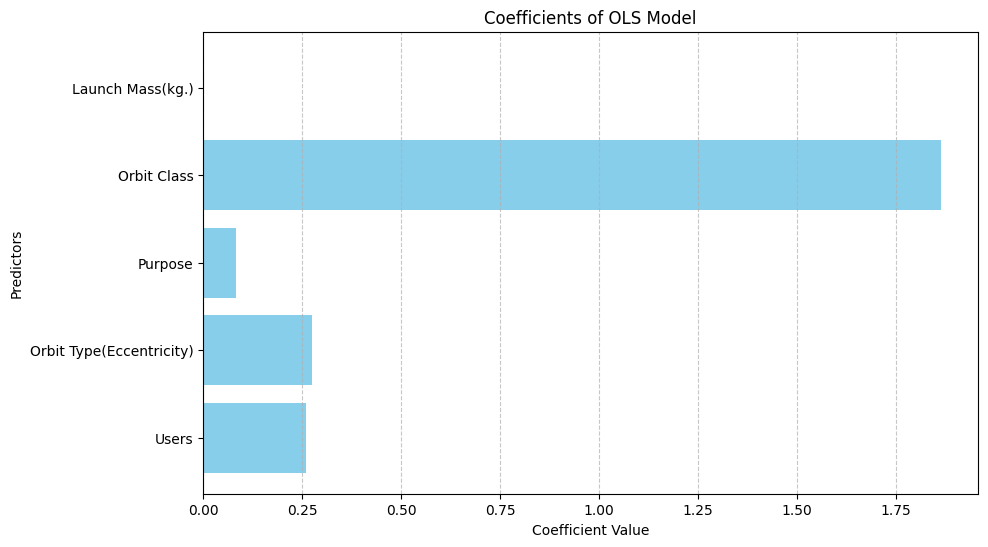

In [20]:
coefficients = results.params[1:]  # Exclude the constant term

# Get the predictor variable names
predictor_names = ['Users','Orbit Type(Eccentricity)','Purpose','Orbit Class','Launch Mass(kg.)']

# Create a bar plot of coefficients
plt.figure(figsize=(10, 6))
plt.barh(predictor_names, coefficients, color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Predictors')
plt.title('Coefficients of OLS Model')
plt.grid(axis='x', linestyle='--', alpha=0.7)

## Hypothesis Test

In [21]:
big3 = mil_df_scatter.loc[mil_df_scatter.Users.isin(['Commercial','Government', 'Military']),['Users','Expected Lifetime (yrs.)']].copy()
com = mil_df_scatter[mil_df_scatter['Users'] == 'Commercial']['Expected Lifetime (yrs.)']
mil = mil_df_scatter[mil_df_scatter['Users'] == 'Military']['Expected Lifetime (yrs.)']
gov = mil_df_scatter[mil_df_scatter['Users'] == 'Government']['Expected Lifetime (yrs.)']
dfs = [com,mil,gov]
ix = ["Commericial", "Military", 'Government']
print(f"Number of carriers: {big3.Users.nunique()}")
combos = combinations(pd.unique(big3.Users), 2)
num_combos = len([i for i in combos])
alpha = 0.05
FWE = 1 - (1-(alpha/num_combos))**num_combos
FWE



Number of carriers: 3


0.04917129629629646

In [22]:
description = []

for i, df in enumerate(dfs):
    description.append([df.mean(), df.median(), df.std(), df.isna().sum(), df.notnull().sum()])

desc_df = pd.DataFrame(
    description,
    columns = ["Mean", "Median", "Standard Deviation", "Amount_Missing", "Amount_Available"], 
    index = ix)
desc_df


,Mean,Median,Standard Deviation,Amount_Missing,Amount_Available
Commericial,5.02,4.00,3.11,0,4097
Military,7.59,5.00,3.94,0,148
Government,7.17,5.00,4.59,0,280


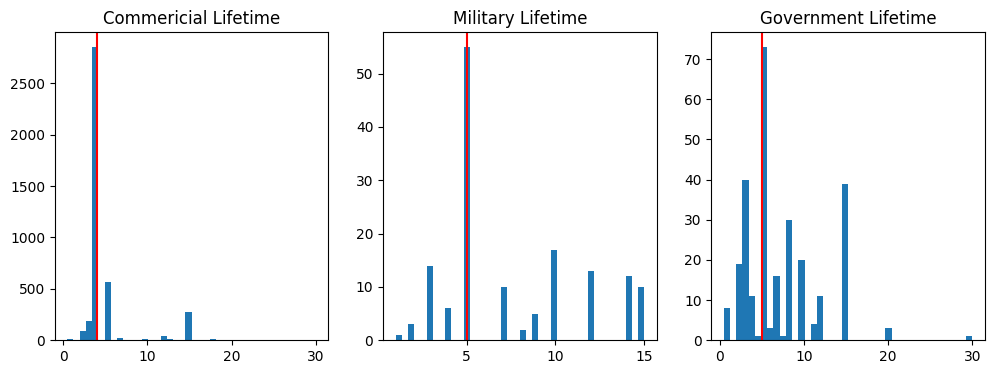

In [23]:
medians = np.array(desc_df['Median'])
titles = ["Commericial Lifetime", "Military Lifetime", 'Government Lifetime']

fig, axs = plt.subplots(1,3, figsize = (12,4))
for ax, df, title, median in zip(axs.flatten(), dfs, titles, medians):
    ax.hist(df, bins = 40)
    ax.set_title(title)
    ax.axvline(median, color = "red", label = f'Mean Lifetime: {median:.2f}')

Number of carriers: 3


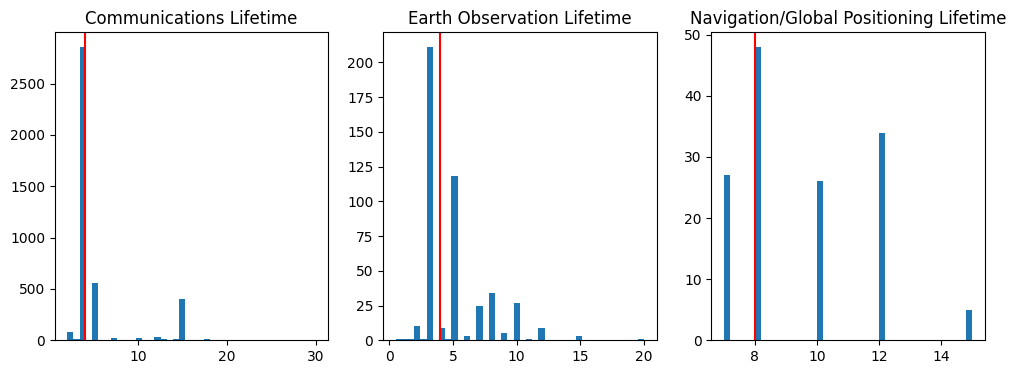

In [24]:
big3 = mil_df_scatter.loc[mil_df_scatter.Purpose.isin(['Communications','Earth Observation', 'Navigation/Global Positioning']),['Purpose','Expected Lifetime (yrs.)']].copy()
com = mil_df_scatter[mil_df_scatter['Purpose'] == 'Communications']['Expected Lifetime (yrs.)']
mil = mil_df_scatter[mil_df_scatter['Purpose'] == 'Earth Observation']['Expected Lifetime (yrs.)']
gov = mil_df_scatter[mil_df_scatter['Purpose'] == 'Navigation/Global Positioning']['Expected Lifetime (yrs.)']
dfs = [com,mil,gov]
ix = ["Communications", "Earth Observation", 'Navigation/Global Positioning']
print(f"Number of carriers: {big3.Purpose.nunique()}")
combos = combinations(pd.unique(big3.Purpose), 2)
num_combos = len([i for i in combos])
alpha = 0.05
FWE = 1 - (1-(alpha/num_combos))**num_combos
description = []

for i, df in enumerate(dfs):
    description.append([df.mean(), df.median(), df.std(), df.isna().sum(), df.notnull().sum()])

desc_df = pd.DataFrame(
    description,
    columns = ["Mean", "Median", "Standard Deviation", "Amount_Missing", "Amount_Available"], 
    index = ix)
medians = np.array(desc_df['Median'])
titles = ["Communications Lifetime", "Earth Observation Lifetime", 'Navigation/Global Positioning Lifetime']

fig, axs = plt.subplots(1,3, figsize = (12,4))
for ax, df, title, median in zip(axs.flatten(), dfs, titles, medians):
    ax.hist(df, bins = 40)
    ax.set_title(title)
    ax.axvline(median, color = "red", label = f'Mean Lifetime: {median:.2f}')

Number of carriers: 3


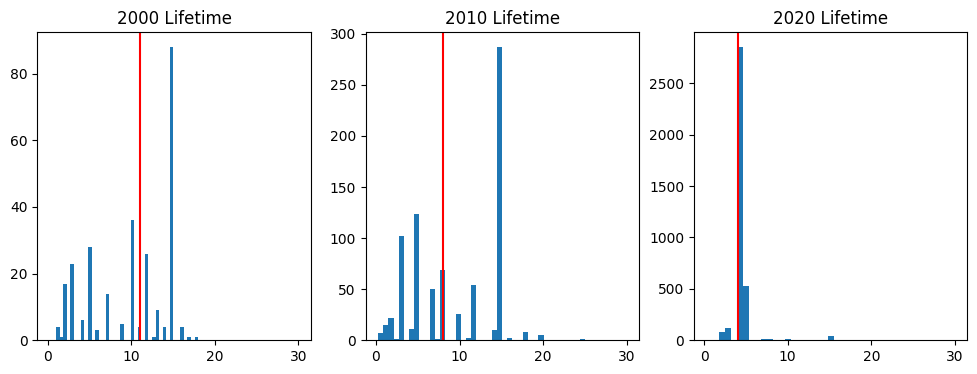

In [25]:
big3 = sat_date.loc[sat_date.Decade.isin([2000,2010, 2020]),['Decade','Expected Lifetime (yrs.)']].copy()
com = sat_date[sat_date['Decade'] == 2000]['Expected Lifetime (yrs.)']
mil = sat_date[sat_date['Decade'] == 2010]['Expected Lifetime (yrs.)']
gov = sat_date[sat_date['Decade'] == 2020]['Expected Lifetime (yrs.)']
dfs = [com,mil,gov]
ix = ["Communications", "Earth Observation", 'Navigation/Global Positioning']
print(f"Number of carriers: {big3.Decade.nunique()}")
combos = combinations(pd.unique(big3.Decade), 2)
num_combos = len([i for i in combos])
alpha = 0.05
FWE = 1 - (1-(alpha/num_combos))**num_combos
description = []

for i, df in enumerate(dfs):
    description.append([df.mean(), df.median(), df.std(), df.isna().sum(), df.notnull().sum()])

desc_df = pd.DataFrame(
    description,
    columns = ["Mean", "Median", "Standard Deviation", "Amount_Missing", "Amount_Available"], 
    index = ix)
medians = np.array(desc_df['Median'])
titles = ["2000 Lifetime", "2010 Lifetime", '2020 Lifetime']

fig, axs = plt.subplots(1,3, figsize = (12,4),sharex=True)
for ax, df, title, median in zip(axs.flatten(), dfs, titles, medians):
    ax.hist(df, bins = 40)
    ax.set_title(title)
    ax.axvline(median, color = "red", label = f'Mean Lifetime: {median:.2f}')

Mean Squared Error: 5.879819121060768
R-squared: 0.5842328333723892


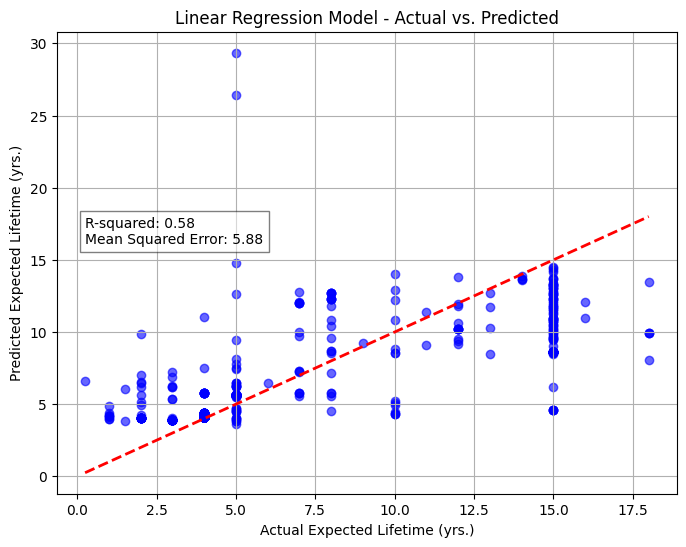

In [26]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)

# Calculate mean squared error and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)
# Step 6: Graph the linear regression model
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.xlabel('Actual Expected Lifetime (yrs.)')
plt.ylabel('Predicted Expected Lifetime (yrs.)')
plt.title('Linear Regression Model - Actual vs. Predicted')
plt.text(min(y_test), max(y_test), f'R-squared: {r2:.2f}\nMean Squared Error: {mse:.2f}', va='top', ha='left', bbox=dict(facecolor='white', alpha=0.5))
plt.grid(True)
plt.show()

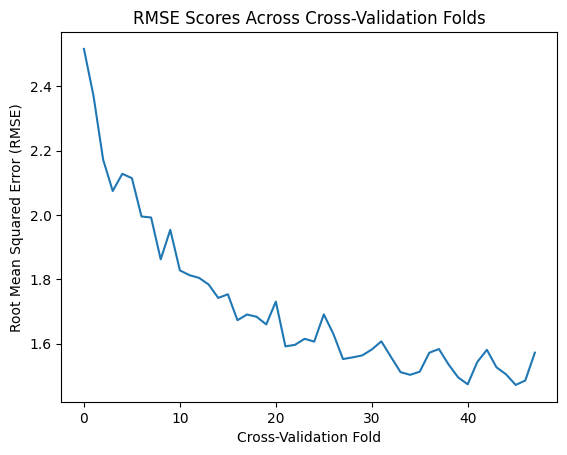

In [27]:
rmse_scores = cross_val_size(linear_model,X, y,50)
plt.xlabel('Cross-Validation Fold')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('RMSE Scores Across Cross-Validation Folds')
plt.plot(rmse_scores)

Text(0.5, 1.0, 'Residuals vs. Predicted: Assessment of Model Fit')

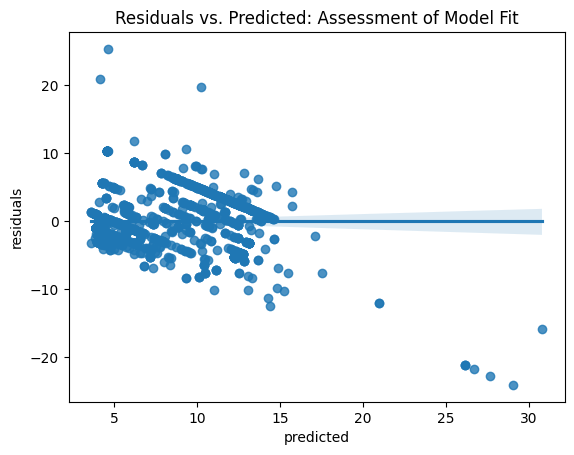

In [28]:
mil_df_scatter['predicted'] = results.predict(X)
mil_df_scatter['residuals'] = y - mil_df_scatter['predicted']

# Created regression plot
sns.regplot(x=mil_df_scatter['predicted'], y=mil_df_scatter['residuals'])
plt.title('Residuals vs. Predicted: Assessment of Model Fit')

Text(0.5, 1.0, 'Quantile-Quantile Plot: Distribution Analysis')

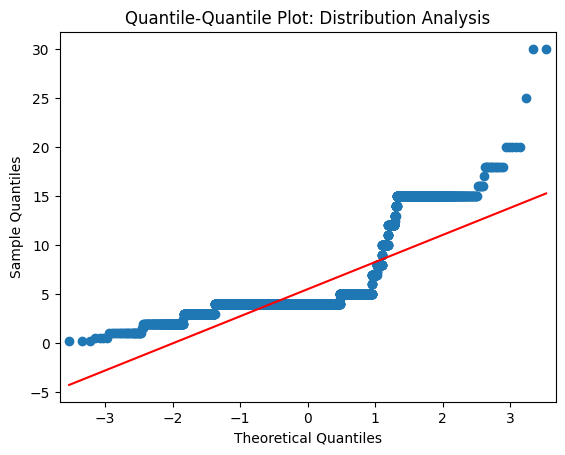

In [29]:
mil_sorted = y.sort_values()
sm.qqplot(mil_sorted, line='r');
plt.title("Quantile-Quantile Plot: Distribution Analysis")

## Predicted vs Residuals

#### Hetero

## Power

### Life Expectancy Distribution

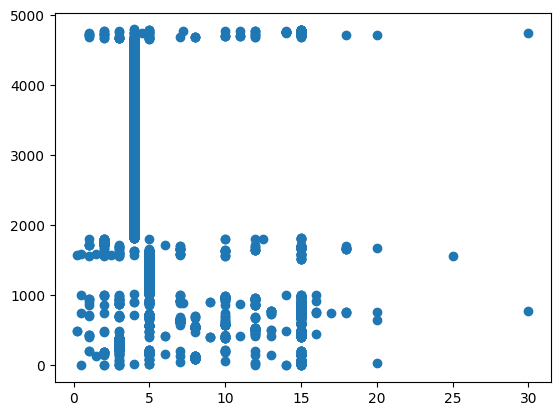

In [30]:
plt.scatter(y, range(len(y)))

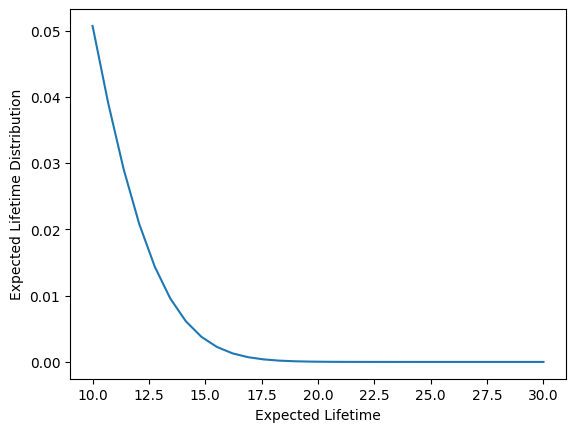

5.5042178712768175


In [31]:
life_mean = y.mean()
life_std = np.std(y)
life_dist= stats.norm.pdf(life_mean,life_std)
# sns.kdeplot(bot_dist)
lin = np.linspace(10, 30, 30)

plt.plot(lin, stats.norm.pdf(lin, loc=life_mean, scale=life_std))
plt.xlabel("Expected Lifetime")
plt.ylabel("Expected Lifetime Distribution")
plt.show()
print(life_mean)


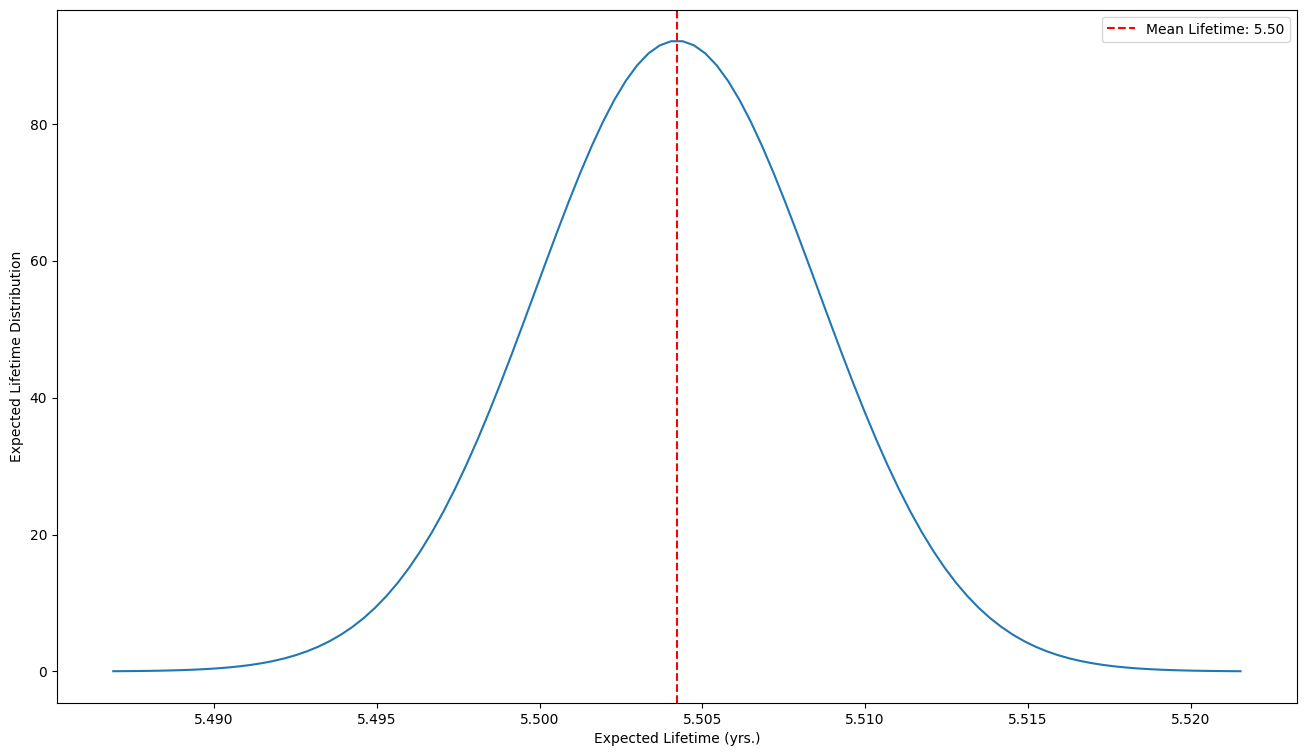

0.0043296760344894835


In [32]:
SE = np.sqrt(.1*(1-.1)/len(y))
lin = np.linspace(life_mean - 4 * SE, life_mean + 4 * SE,num=100)
plt.figure(figsize=(16,9))
plt.plot(lin, stats.norm.pdf(lin, loc=life_mean, scale=SE))
plt.xlabel("Expected Lifetime (yrs.)")
plt.ylabel("Expected Lifetime Distribution")
plt.axvline(x=life_mean, color='r', linestyle='--', label=f'Mean Lifetime: {life_mean:.2f}')
plt.legend()
plt.show()
print(SE)

## Regression Model

## Confusion Map

c:\Users\beans\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


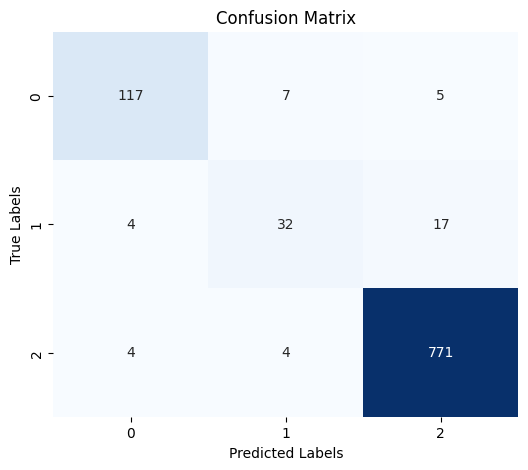

In [33]:
mil_df_scatter['Lifetime Class'] = pd.cut(mil_df_scatter['Expected Lifetime (yrs.)'], bins=[-np.inf, 5, 10, np.inf], labels=['Short', 'Medium', 'Long'])

# Prepare the data
X = mil_df_scatter[['Users', 'Purpose', 'Class of Orbit', 'Type of Orbit', 'Launch Mass (kg.)', 'Country of Operator/Owner']]
y = mil_df_scatter['Lifetime Class']

# Encode categorical variables using get_dummies
X = pd.get_dummies(X, drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the logistic regression model
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logreg_model.predict(X_test)

# Create the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Critical Value

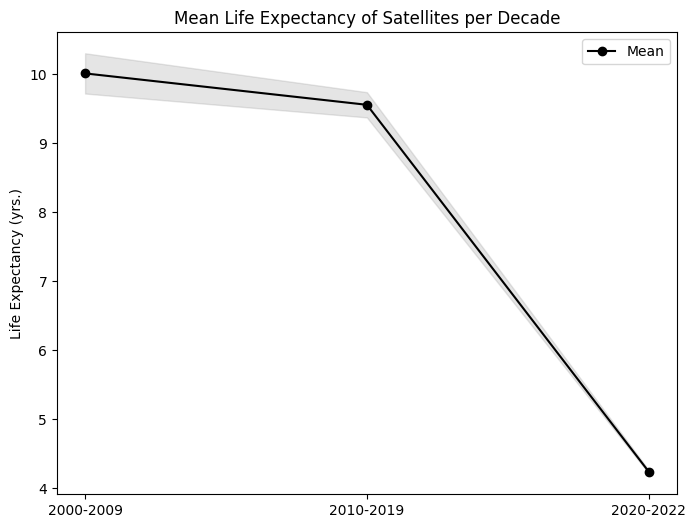

In [34]:
group1 = sat_date[sat_date['Decade'] == 2000]['Expected Lifetime (yrs.)']
group2 = sat_date[sat_date['Decade'] == 2010]['Expected Lifetime (yrs.)']
group3 = sat_date[sat_date['Decade'] == 2020]['Expected Lifetime (yrs.)']
# Perform one-way ANOVA test
f_statistic, p_value = stats.f_oneway(group1, group2, group3)

# Calculate means and standard errors
mean_group1 = np.mean(group1)
mean_group2 = np.mean(group2)
mean_group3 = np.mean(group3)
std_err_group1 = np.std(group1, ddof=1) / np.sqrt(len(group1))
std_err_group2 = np.std(group2, ddof=1) / np.sqrt(len(group2))
std_err_group3 = np.std(group3, ddof=1) / np.sqrt(len(group3))

# Create a line plot with confidence intervals
plt.figure(figsize=(8, 6))
plt.plot([1, 2, 3], [mean_group1, mean_group2, mean_group3], marker='o', color='black', label='Mean')
plt.fill_between([1, 2, 3], [mean_group1 - std_err_group1, mean_group2 - std_err_group2, mean_group3 - std_err_group3],
                 [mean_group1 + std_err_group1, mean_group2 + std_err_group2, mean_group3 + std_err_group3], color='gray', alpha=0.2)
plt.xticks([1, 2, 3], ['2000-2009', '2010-2019', '2020-2022'])
plt.ylabel('Life Expectancy (yrs.)')
plt.title(f'Mean Life Expectancy of Satellites per Decade')
plt.legend()



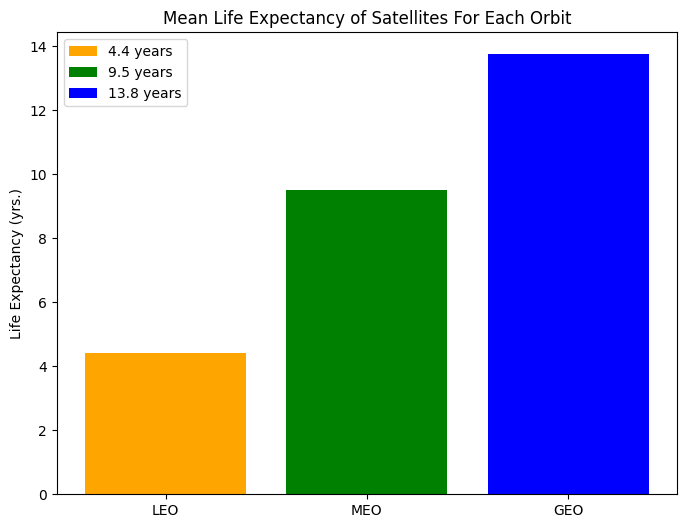

In [68]:
group1 = sat_date[sat_date['Class of Orbit'] == 'LEO']['Expected Lifetime (yrs.)']
group2 = sat_date[sat_date['Class of Orbit'] == 'MEO']['Expected Lifetime (yrs.)']
group3 = sat_date[sat_date['Class of Orbit'] == 'GEO']['Expected Lifetime (yrs.)']
# Perform one-way ANOVA test
f_statistic, p_value = stats.f_oneway(group1, group2, group3)

# Calculate means and standard errors
mean_group1 = np.mean(group1)
mean_group2 = np.mean(group2)
mean_group3 = np.mean(group3)
std_err_group1 = np.std(group1, ddof=1) / np.sqrt(len(group1))
std_err_group2 = np.std(group2, ddof=1) / np.sqrt(len(group2))
std_err_group3 = np.std(group3, ddof=1) / np.sqrt(len(group3))

# Create a line plot with confidence intervals
plt.figure(figsize=(8, 6))
mean_life_chart = plt.bar([1, 2, 3], [mean_group1, mean_group2, mean_group3], label= [f'{mean_group1:.1f} years', f'{mean_group2:.1f} years', f'{mean_group3:.1f} years'], color=['orange','green','blue'])
plt.xticks([1, 2, 3], ['LEO', 'MEO', 'GEO'])
plt.ylabel('Life Expectancy (yrs.)')
plt.title(f'Mean Life Expectancy of Satellites For Each Orbit')
plt.legend()

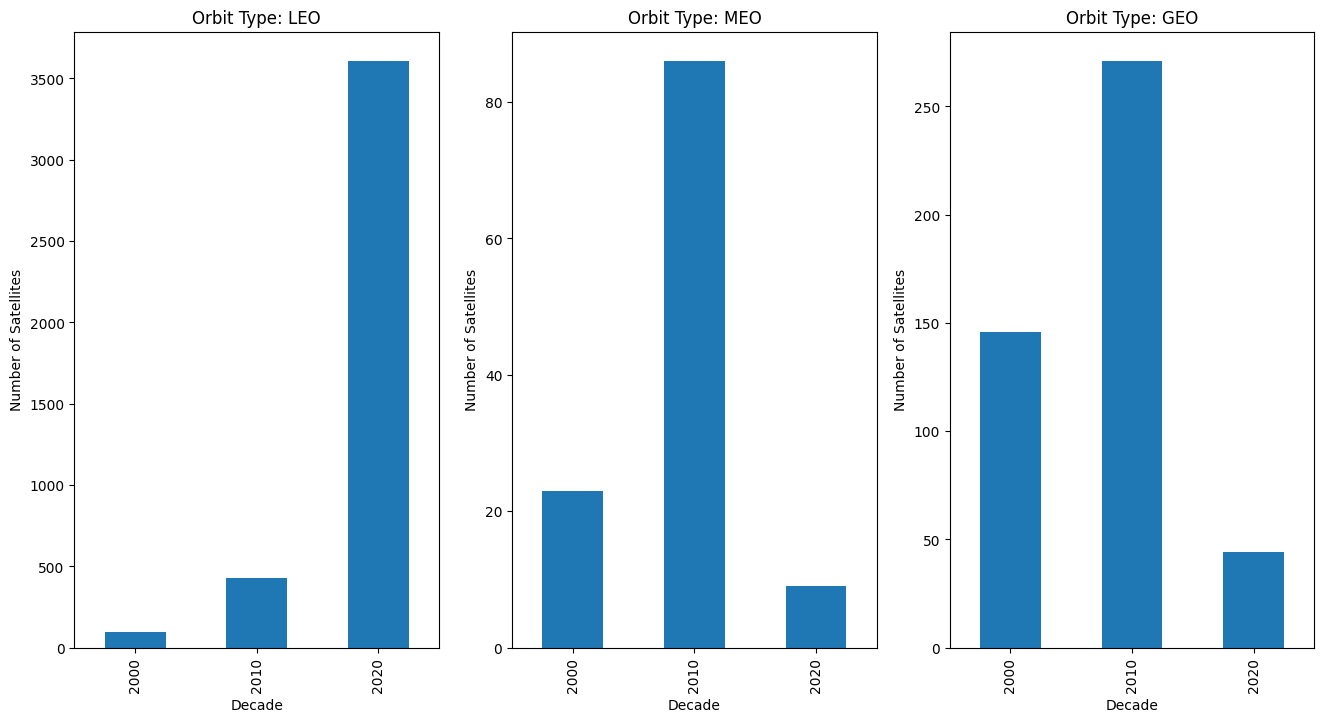

In [36]:
data = sat_cleaned[sat_cleaned['Decade'] >= 2000]
grouped = data.groupby(['Class of Orbit', 'Decade']).size().unstack(fill_value=0)
# Plot histograms for each orbit type
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))

orbit_types = ['LEO', 'MEO', 'GEO']
for i, orbit_type in enumerate(orbit_types):
    ax = axes[i]
    grouped.loc[orbit_type].plot(kind='bar', ax=ax)
    ax.set_title(f'Orbit Type: {orbit_type}')
    ax.set_ylabel('Number of Satellites')


In [37]:
X = sm.add_constant(mil_df_scatter[['OrbitTypeMap','PurposeMaps','OrbitClassMap','DecadeMap']])
y = mil_df_scatter['Expected Lifetime (yrs.)']
# Step 3: Build the OLS model
ols_model = sm.OLS(y, X)
results = ols_model.fit()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(results.summary())

                               OLS Regression Results                               
Dep. Variable:     Expected Lifetime (yrs.)   R-squared:                       0.494
Model:                                  OLS   Adj. R-squared:                  0.494
Method:                       Least Squares   F-statistic:                     1172.
Date:                      Wed, 09 Aug 2023   Prob (F-statistic):               0.00
Time:                              09:59:56   Log-Likelihood:                -11307.
No. Observations:                      4801   AIC:                         2.262e+04
Df Residuals:                          4796   BIC:                         2.266e+04
Df Model:                                 4                                         
Covariance Type:                  nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

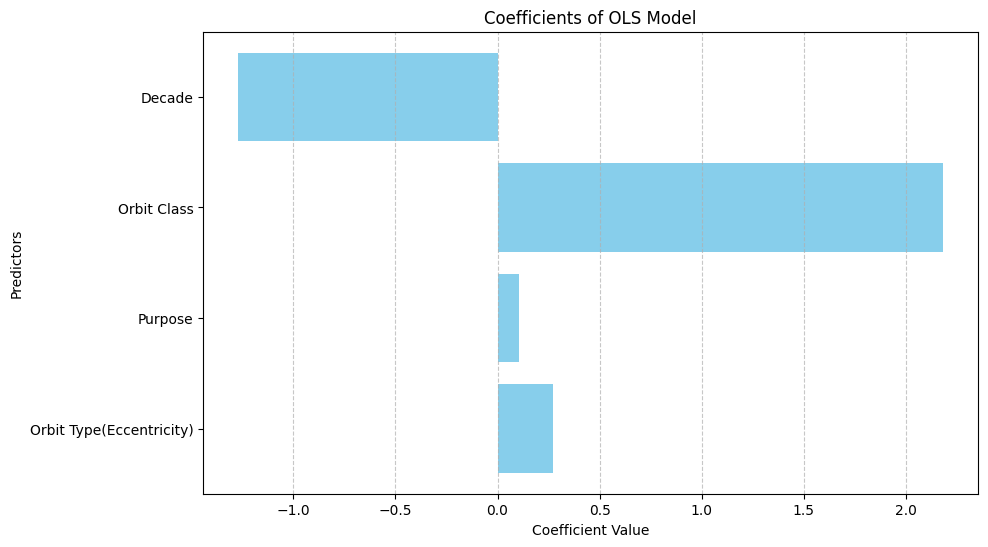

In [38]:
coefficients = results.params[1:]  # Exclude the constant term

# Get the predictor variable names
predictor_names = ['Orbit Type(Eccentricity)','Purpose','Orbit Class', 'Decade']

# Create a bar plot of coefficients
plt.figure(figsize=(10, 6))
plt.barh(predictor_names, coefficients, color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Predictors')
plt.title('Coefficients of OLS Model')
plt.grid(axis='x', linestyle='--', alpha=0.7)

Mean Squared Error: 6.725565451000023
R-squared: 0.5244293686663002


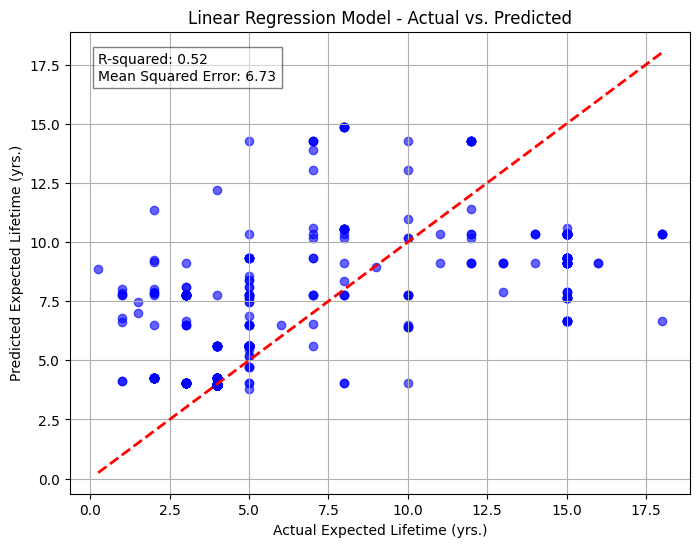

In [39]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)

# Calculate mean squared error and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)
# Step 6: Graph the linear regression model
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.xlabel('Actual Expected Lifetime (yrs.)')
plt.ylabel('Predicted Expected Lifetime (yrs.)')
plt.title('Linear Regression Model - Actual vs. Predicted')
plt.text(min(y_test), max(y_test), f'R-squared: {r2:.2f}\nMean Squared Error: {mse:.2f}', va='top', ha='left', bbox=dict(facecolor='white', alpha=0.5))
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Residuals vs. Predicted: Assessment of Model Fit')

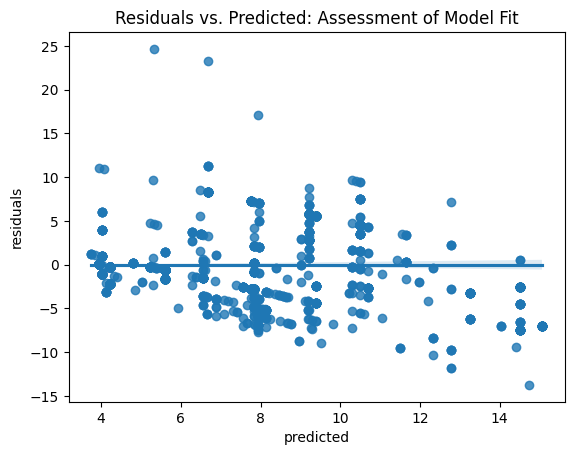

In [40]:
mil_df_scatter['predicted'] = results.predict(X)
mil_df_scatter['residuals'] = y - mil_df_scatter['predicted']

# Created regression plot
sns.regplot(x=mil_df_scatter['predicted'], y=mil_df_scatter['residuals'])
plt.title('Residuals vs. Predicted: Assessment of Model Fit')

<Axes: >

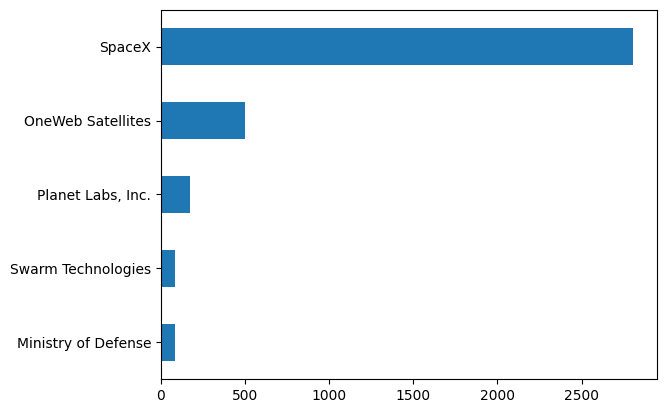

In [41]:

top_5_operator = sat_cleaned['Operator/Owner'].value_counts().head(5)
top_5_operator.sort_values(inplace=True, ascending = True)
top_5_operator.plot(kind='barh')

<Figure size 1000x600 with 0 Axes>

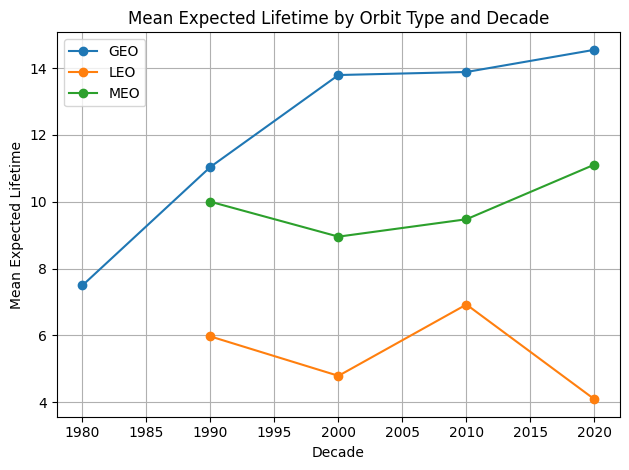

In [42]:
no_eli = mil_df_scatter[mil_df_scatter['Class of Orbit'] != 'Elliptical']
orbit_decade_means = no_eli[['Expected Lifetime (yrs.)','Decade','Class of Orbit']].groupby(['Class of Orbit', 'Decade']).mean()
orbit_decade_means = orbit_decade_means.reset_index()
pivot_table = orbit_decade_means.pivot(index='Decade', columns='Class of Orbit', values='Expected Lifetime (yrs.)')

# Create a line plot to visualize mean expected lifetime by orbit type
plt.figure(figsize=(10, 6))
pivot_table.plot(kind='line', marker='o')
plt.xlabel('Decade')
plt.ylabel('Mean Expected Lifetime')
plt.title('Mean Expected Lifetime by Orbit Type and Decade')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()